## INFOSYS 722 Assignement Iteration 4 - Sub-iteration 2

In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math

In [3]:
spark = SparkSession.builder.appName('infosys722-i4-i2').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/11 23:33:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
integrated_purchase_detail = spark.read.options(compression='gzip').format('parquet').load(
    './Ready Datasets/purchase_detail_v001')
integrated_sales = spark.read.options(compression='gzip').format('parquet').load(
    './Ready Datasets/sales_v001')

In [5]:
period = 60

In [6]:
sales_frequency = integrated_sales.groupBy('Brand').agg(
    F.count('Brand').alias('count')).withColumn('Frequency', F.col('count') / period)

In [7]:
total_brand = integrated_sales.select('Brand').distinct().count()
total_dollars = integrated_sales.agg(F.sum('SalesDollars')).collect()[0][0]
total_sales_dollars = integrated_sales.groupBy('Brand').agg(
    F.sum('SalesDollars').alias('TotalSalesDollars')
).orderBy('TotalSalesDollars', ascending=False)
windowval = (Window.rowsBetween(Window.unboundedPreceding, 0))
abc = (total_sales_dollars.withColumn('Seq', F.lit(1))
 .withColumn('BrandPercentile', F.sum('Seq').over(windowval))
 .withColumn('BrandPercentile', F.col('BrandPercentile') / total_brand)
 .withColumn('SalesPercentile', F.sum('TotalSalesDollars').over(windowval))
 .withColumn('SalesPercentile', F.col('SalesPercentile') / total_dollars))

In [8]:
abc.where('SalesPercentile <= 0.7').orderBy('SalesPercentile', ascending=False).show()

23/10/11 23:33:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/11 23:33:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/11 23:33:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/11 23:33:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/11 23:33:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+------------------+---+-------------------+------------------+
|Brand| TotalSalesDollars|Seq|    BrandPercentile|   SalesPercentile|
+-----+------------------+---+-------------------+------------------+
| 6960|429.42999267578125|  1|0.20616113744075829|0.6998582455305453|
|  782| 429.9200134277344|  1|0.20589784096893102|  0.69955646737617|
| 3362| 431.2799873352051|  1|0.20563454449710375|0.6992543448640168|
|11488|431.61999320983887|  1|0.20537124802527645|0.6989512666421488|
|37235|431.63999938964844|  1|0.20510795155344919|0.6986479494841397|
|26163| 431.6800060272217|  1|0.20484465508162192|0.6983446182669635|
|24929|431.82000732421875|  1|0.20458135860979462|0.6980412589354742|
| 5694|433.60998916625977|  1|0.20431806213796735|0.6977378012193035|
| 5096| 434.5799922943115|  1| 0.2040547656661401|0.6974330856091201|
| 5296| 434.8499984741211|  1| 0.2037914691943128| 0.697127688337761|
|32368| 435.6600036621094|  1|0.20352817272248552|0.6968221013219312|
|10727| 437.51998996

In [9]:
importance_brands = spark.createDataFrame(abc.where('SalesPercentile <= 0.7').select('Brand').toPandas())

23/10/11 23:33:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/11 23:33:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/11 23:33:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/11 23:33:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/11 23:33:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [10]:
selected_integrated_sales = importance_brands.join(
    integrated_sales, on='Brand', how='left').join(
    sales_frequency, on='Brand', how='left'
)

In [11]:
selected_integrated_sales.select('SalesQuantity').summary().show()

+-------+-----------------+
|summary|    SalesQuantity|
+-------+-----------------+
|  count|            17516|
|   mean|3.453756565425896|
| stddev|8.468994491850651|
|    min|                1|
|    25%|                1|
|    50%|                2|
|    75%|                3|
|    max|              432|
+-------+-----------------+



{'whiskers': [<matplotlib.lines.Line2D at 0x7f7959ca4280>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7959ca4820>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7959cc3f70>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7959ca4dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7959ca5090>],
 'means': []}

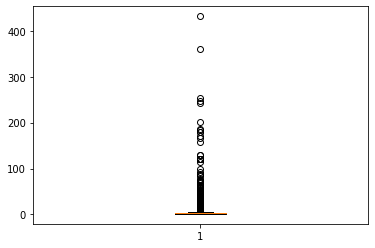

In [12]:
plt.boxplot(selected_integrated_sales.toPandas()['SalesQuantity'])

In [13]:
def remove_extreme_by_z_scores(dataframe, column, threshold = 1):
    mean, std = dataframe.agg(F.mean(column), F.stddev(column)).collect()[0]
    dataframe = dataframe.withColumn('z_scores', (F.col(column) - mean) / std)
    return dataframe.where(F.col('z_scores') <= threshold).drop('z_scores')

selected_integrated_sales = remove_extreme_by_z_scores(selected_integrated_sales, 'SalesQuantity')
selected_integrated_sales.select('SalesQuantity').summary().show()

+-------+------------------+
|summary|     SalesQuantity|
+-------+------------------+
|  count|             16641|
|   mean|   2.4248542755844|
| stddev|1.9681704011242749|
|    min|                 1|
|    25%|                 1|
|    50%|                 2|
|    75%|                 3|
|    max|                11|
+-------+------------------+



{'whiskers': [<matplotlib.lines.Line2D at 0x7f7959c548e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7959c54340>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7959c54bb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f79581eca30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f79581ec280>],
 'means': []}

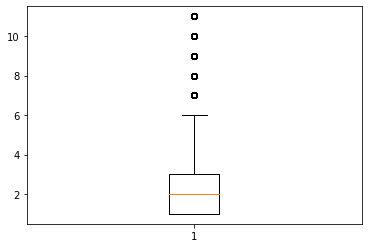

In [14]:
plt.boxplot(selected_integrated_sales.toPandas()['SalesQuantity'])

## Modeling

In [15]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, GBTClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

In [16]:
def evaluate_regression_model(result, labelCol, predictionCol='prediction', metrics = ['rmse', 'mse', 'mae', 'r2']):
    results = [(metric, 
                RegressionEvaluator(labelCol=labelCol, metricName=metric, predictionCol=predictionCol).evaluate(result)) 
               for metric in metrics]
    for metric, result in results:
        print(f'{metric}: {result}')
    return dict(results)

def evaluate_classification_model(result, labelCol, predictionCol='prediction', metrics = ['f1', 'accuracy']):
    results = [(metric, 
                MulticlassClassificationEvaluator(
                    labelCol=labelCol, metricName=metric, predictionCol=predictionCol).evaluate(result)) 
               for metric in metrics]
    for metric, v in results:
        print(f'{metric}: {v}')
    return dict(results)
    
def get_string_indexers(dataframe, suffix='_index'):
    indexers = []
    for feature, dtype in dataframe.dtypes:
        if dtype == 'string':
            indexers.append(StringIndexer(inputCol=feature, outputCol=feature + suffix))
    return indexers

def generate_baseline(dataframe, target):
    target_mean = dataframe.agg(F.mean(target)).collect()[0][0]
    return dataframe.withColumn('baseline_prediction', F.lit(target_mean))

def balance(dataframe, target, size=None):
    categories = dataframe.groupBy(target).agg(F.count(target).alias('count'))
    if size is None:
        size = int(categories.agg(F.mean('count')).collect()[0][0])
    balanced_df = spark.createDataFrame([], dataframe.schema)
    for category, count in categories.collect():
        if count > size:
            sample = dataframe.where(F.col(target) == category).orderBy(F.rand(13)).limit(size)
        else:
            ratio = math.ceil(size/count)
            sample = dataframe.where(F.col(target) == category).withColumn(
                'dummy', F.explode(F.array([F.lit(i) for i in range(ratio)]))).drop('dummy').orderBy(F.rand(13)).limit(size)
        balanced_df = balanced_df.unionAll(sample)
    return balanced_df

def print_evaluation(model, train, test, target, transformer, evaluate_function=evaluate_regression_model):
    print('Training data evaluation metrics:')
    result = model.transform(transformer.transform(train))
    evaluate_function(result, target)

    print('Testing data evaluation metrics:')
    result = model.transform(transformer.transform(test))
    evaluate_function(result, target)

def print_feature_importance(model, train, rounding=6):
    attrs = train.schema["features"].metadata['ml_attr']['attrs']
    feature_names = []
    for key, feature_list in attrs.items():
        feature_names = feature_names + feature_list
    feature_importances = [(f['name'], float(round(model.featureImportances[f['idx']], rounding))) for f in feature_names]
    spark.createDataFrame(feature_importances, ['feature', 'importance']).orderBy('importance', ascending=False).show()

### Compare Algorithm Sales

In [17]:
train, test = selected_integrated_sales.randomSplit([0.7, 0.3], seed=13)

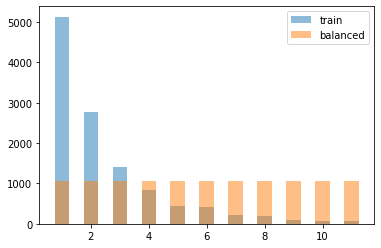

In [18]:
plt.hist(train.toPandas()['SalesQuantity'], bins=[i+0.5 for i in range(0, 12)], rwidth=0.5, alpha=0.5, label='train')
balanced_train = balance(train, 'SalesQuantity')
plt.hist(balanced_train.toPandas()['SalesQuantity'], bins=[i+0.5 for i in range(0, 12)], rwidth=0.5, alpha=0.5, label='balanced')
plt.legend(loc='upper right')
plt.show()

In [19]:
train = balanced_train

In [20]:
transformation_pipeline = Pipeline(stages=get_string_indexers(selected_integrated_sales) + [
    VectorAssembler(inputCols=[
        'SalesPrice', 'DayOfMonth', 'PurchasePrice',
        'VendorNumber_index', 'DayOfWeek_index', 'Frequency'], 
                    outputCol='features')
])
transformer = transformation_pipeline.fit(selected_integrated_sales)

In [21]:
# Decision Tree
dtr = DecisionTreeClassifier(maxDepth=10, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
model = dtr.fit(transformer.transform(train))
print_evaluation(model, train, test, 'SalesQuantity', transformer, evaluate_function=evaluate_classification_model)

Training data evaluation metrics:


f1: 0.4778919320628107
accuracy: 0.5006450503139245
Testing data evaluation metrics:


f1: 0.266785856686485
accuracy: 0.22220003992812937


In [22]:
# Random Forest
rfr = RandomForestClassifier(maxDepth=10, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
model = rfr.fit(transformer.transform(train))
print_evaluation(model, train, test, 'SalesQuantity', transformer, evaluate_function=evaluate_classification_model)

23/10/11 23:35:21 WARN DAGScheduler: Broadcasting large task binary with size 1302.6 KiB
23/10/11 23:35:28 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/11 23:35:36 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


Training data evaluation metrics:


23/10/11 23:35:51 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/10/11 23:35:57 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


f1: 0.7064555505383495
accuracy: 0.7210802442590523
Testing data evaluation metrics:


23/10/11 23:35:59 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/10/11 23:36:00 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


f1: 0.2861838509126349
accuracy: 0.24695548013575563


In [23]:
# Naive Bayes
nb = NaiveBayes(labelCol='SalesQuantity', featuresCol='features')
model = nb.fit(transformer.transform(train))
print_evaluation(model, train, test, 'SalesQuantity', transformer, evaluate_function=evaluate_classification_model)

Training data evaluation metrics:


23/10/11 23:36:12 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/11 23:36:12 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


f1: 0.053058888427765336
accuracy: 0.07301969553625183
Testing data evaluation metrics:
f1: 0.05714881216007275
accuracy: 0.043322020363345974


In [24]:
transformation_pipeline = Pipeline(stages=get_string_indexers(selected_integrated_sales) + [
    VectorAssembler(inputCols=[
        'SalesPrice_log10', 'DayOfMonth', 'PurchasePrice_log10',
        'VendorNumber_index', 'DayOfWeek_index', 'Frequency'], 
                    outputCol='features')
])
transformer = transformation_pipeline.fit(selected_integrated_sales)

In [25]:
# Decision Tree
dtr = DecisionTreeClassifier(maxDepth=10, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
model = dtr.fit(transformer.transform(train))
print_evaluation(model, train, test, 'SalesQuantity', transformer, evaluate_function=evaluate_classification_model)

Training data evaluation metrics:


f1: 0.4778919320628107
accuracy: 0.5006450503139245
Testing data evaluation metrics:


f1: 0.266785856686485
accuracy: 0.22220003992812937


In [26]:
# Random Forest
rfr = RandomForestClassifier(maxDepth=10, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
model = rfr.fit(transformer.transform(train))
print_evaluation(model, train, test, 'SalesQuantity', transformer, evaluate_function=evaluate_classification_model)

23/10/11 23:37:17 WARN DAGScheduler: Broadcasting large task binary with size 1301.9 KiB
23/10/11 23:37:21 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/11 23:37:27 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


Training data evaluation metrics:


23/10/11 23:37:42 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/10/11 23:37:46 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


f1: 0.7064555505383495
accuracy: 0.7210802442590523
Testing data evaluation metrics:


23/10/11 23:37:48 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/10/11 23:37:49 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


f1: 0.2861838509126349
accuracy: 0.24695548013575563


### Data Mining - Sales Model

In [27]:
# Random Forest
transformation_pipeline = Pipeline(stages=get_string_indexers(selected_integrated_sales) + [
    VectorAssembler(inputCols=[
        'SalesPrice', 'DayOfMonth', 'PurchasePrice',
        'VendorNumber_index', 'DayOfWeek_index', 'Frequency'], 
                    outputCol='features')
])
transformer = transformation_pipeline.fit(selected_integrated_sales)

test_data_size = 1 / (math.sqrt(5) + 1)
print(f'Test data size is {test_data_size}')
train, test = selected_integrated_sales.randomSplit([1-test_data_size, test_data_size], seed=13)
train = balance(train, 'SalesQuantity')

Test data size is 0.3090169943749474


In [28]:
cache = {}
def try_depth(max_depth):
    if cache.get(max_depth) is not None:
        return cache.get(max_depth)
    print('===============================================')
    print(f'Trying maxDepth: {max_depth}')
    rfr = RandomForestClassifier(maxDepth=max_depth, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
    model = rfr.fit(transformer.transform(train))
    print('training:')
    result = model.transform(transformer.transform(train))
    _ = evaluate_classification_model(result, 'SalesQuantity')
    print('testing:')
    result = model.transform(transformer.transform(test))
    cache[max_depth] = evaluate_classification_model(result, 'SalesQuantity')
    return cache[max_depth]

In [29]:
def find_best_max_depth(left, right):
    if left == right:
        return left
    left_metric, right_metric = try_depth(left), try_depth(right)
    if left_metric['accuracy'] < right_metric['accuracy']:
        middle = math.ceil((left + right) / 2)
        return find_best_max_depth(middle, right)
    else:
        middle = math.floor((left + right) / 2)
        return find_best_max_depth(left, middle)

find_best_max_depth(3, 15)

Trying maxDepth: 3


training:


f1: 0.1211756793586338
accuracy: 0.1838228885208751
testing:


f1: 0.26636618070993134
accuracy: 0.29442508710801396
Trying maxDepth: 15


23/10/11 23:38:48 WARN DAGScheduler: Broadcasting large task binary with size 1319.7 KiB
23/10/11 23:38:53 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/11 23:39:00 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/10/11 23:39:10 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/10/11 23:39:22 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
23/10/11 23:39:38 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
23/10/11 23:39:55 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
23/10/11 23:40:16 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB


training:


23/10/11 23:40:42 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
23/10/11 23:40:49 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


f1: 0.9595767601949199
accuracy: 0.9600801882681077
testing:


23/10/11 23:40:53 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
23/10/11 23:40:55 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


f1: 0.3052479230567588
accuracy: 0.2715834301200155
Trying maxDepth: 9


23/10/11 23:41:19 WARN DAGScheduler: Broadcasting large task binary with size 1319.7 KiB
23/10/11 23:41:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


training:


23/10/11 23:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1974.0 KiB
23/10/11 23:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1974.0 KiB


f1: 0.6002425398679786
accuracy: 0.6226793340887301
testing:


23/10/11 23:41:40 WARN DAGScheduler: Broadcasting large task binary with size 1897.4 KiB
23/10/11 23:41:41 WARN DAGScheduler: Broadcasting large task binary with size 1897.4 KiB


f1: 0.30024416441326907
accuracy: 0.28087495160665893
Trying maxDepth: 6


training:


f1: 0.31834265852335475
accuracy: 0.3530027019959906
testing:
f1: 0.29087097701286496
accuracy: 0.2951993805652342
Trying maxDepth: 5


training:


f1: 0.24718808140917614
accuracy: 0.2857142857142857
testing:


f1: 0.28409900229428925
accuracy: 0.2969415408439799


5

In [30]:
# Random Forest
rfr = RandomForestClassifier(maxDepth=5, labelCol='SalesQuantity', featuresCol='features', maxBins=256)
model = rfr.fit(transformer.transform(train))
print_evaluation(model, train, test, 'SalesQuantity', transformer, evaluate_function=evaluate_classification_model)

Training data evaluation metrics:


f1: 0.24718808140917614
accuracy: 0.2857142857142857
Testing data evaluation metrics:
f1: 0.28409900229428925
accuracy: 0.2969415408439799


In [31]:
print_feature_importance(model, transformer.transform(train))

+------------------+----------+
|           feature|importance|
+------------------+----------+
|         Frequency|  0.301711|
|        SalesPrice|  0.176445|
|   DayOfWeek_index|  0.175172|
|     PurchasePrice|  0.157284|
|VendorNumber_index|  0.100708|
|        DayOfMonth|   0.08868|
+------------------+----------+



In [32]:
integrated_sales.groupBy('Brand').agg(F.count('Brand').alias('count')).summary().show()

+-------+------------------+------------------+
|summary|             Brand|             count|
+-------+------------------+------------------+
|  count|              3798|              3798|
|   mean|15094.384149552396|10.172985781990521|
| stddev|13184.954924953821| 9.884283717826671|
|    min|               100|                 1|
|    25%|            3919.0|                 3|
|    50%|            8895.0|                 7|
|    75%|           23764.0|                15|
|    max|               999|                52|
+-------+------------------+------------------+

